# Economicos

In [16]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -U -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido

In [17]:
import pandas as pd
import numpy as np
df = pd.read_parquet('../datasets/economicos/raw/full_dedup_economicos_step0.parquet');
df.sample(3)

,url,description,price,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,title,address,owner,_price
722038,https://www.economicos.cl/propiedades/arriendo...,"Departamento de un dormitorio, impecable de pr...",$ 230.000,Departamento,Arriendo,Valparaíso,Valparaíso,2019-09-04 17:11:08,1.0,1.0,35.0,35.0,None,Arriendo departamento de un dormitorio Av Colón,"avenida colon 2999 Valparaíso, Valparaíso",Rodrigo Pérez,8.214197
511309,https://www.economicos.cl/propiedades/departam...,Novena Propiedades Arrienda departamento en Ed...,$ 380.000,Departamento,Arriendo,Araucanía,Temuco,2021-03-12 11:59:46,2.0,2.0,62.0,NaN,None,Departamento Gabriela Mistral,"Gabriela Mistral 0850 Temuco, Araucanía",Novena Propiedades SPA,12.943308
582162,https://www.economicos.cl/propiedades/departam...,"Nuevo, para disfrutar del mejor sector de la c...",160 UF,Departamento,Arriendo,Metropolitana de Santiago,Lo Barnechea,2022-02-23 22:06:00,5.0,6.0,415.0,653.0,El Mercurio,Departamento en Arriendo en Lo Barnechea 5 dor...,"Colegio Newland, sin comisión al comprador, de...",Coldwell Banker,160.000000


In [18]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
category_columns=("property_type", "transaction_type", "state", "county", "rooms", "bathrooms", "m_built", "m_size", "source", )
# TODO: Estudiar implicancia de valores nulos en categorias y numeros
df_converted = df.fillna(dict(
        property_type = "None",
        transaction_type = "None",
        state = "None",
        county = "None",
        rooms = -1,
        bathrooms = -1,
        m_built = -1,
        m_size = -1,
        source = "None"
)).fillna(-1).astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})
df_converted = df.replace(to_replace="None", value=np.nan).replace(to_replace=-1, value=np.nan).dropna().astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})

syn = Synthetic(df_converted, 
        id="url", 
        category_columns=category_columns,
        text_columns=("description", "price", "title", "address", "owner", ),
        exclude_columns=tuple(),
        synthetic_folder = "../datasets/economicos/synth",
        models=['copulagan', 'tvae', 'gaussiancopula', 'ctgan', 'smote-enc', 'tddpm_mlp'],
        n_sample = df_converted.shape[0],
        target_column="_price",
        max_cpu_pool=1
)


In [19]:
%%capture
syn.process()
#syn.process(remaining_columns=("property_type", "transaction_type", "state",))
syn.process_scores()


## Metricas
### Continuas

In [20]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
9,_price,"[12500.0, 10500.0, 11500.0, 8500.0, 9000.0]","[104, 99, 91, 86, 85]","[0.00471462894963507, 0.00448796409628723, 0.0...",False,22059.0,0.0,110378.900259,32745.67551,174559.244908,...,0.004715,5083.869574,0.262868,6.270122,11.759796,2040.766084,12000.0,32000.0,58942.0,262695.428


### Categoricas

In [21]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,bathrooms,"[2.0, 1.0, 3.0, 4.0, 5.0]","[7511, 5440, 4486, 2665, 1084]","[0.3404959426991251, 0.2466113604424498, 0.203...",True,22059.0,22059.0
1,m_built,"[140.0, 60.0, 120.0, 50.0, 70.0]","[700, 467, 444, 431, 415]","[0.031733079468697585, 0.021170497302688246, 0...",True,22059.0,22059.0
2,source,[El Mercurio],[22059],[1.0],True,22059.0,22059.0
3,rooms,"[3.0, 2.0, 4.0, 1.0, 5.0]","[6355, 4614, 4168, 2671, 2232]","[0.2880910286051045, 0.20916632666938664, 0.18...",True,22059.0,22059.0
4,m_size,"[5000.0, 50.0, 60.0, 200.0, 70.0]","[601, 342, 321, 285, 281]","[0.027245115372410353, 0.015503875968992248, 0...",True,22059.0,22059.0
5,property_type,"[Departamento, Casa, Oficina o Casa Oficina, P...","[10592, 8911, 1553, 413, 255]","[0.480166825332064, 0.40396210163652024, 0.070...",True,22059.0,22059.0
6,transaction_type,"[Venta, Arriendo, Busco arriendo, Compro]","[17540, 4517, 1, 1]","[0.7951403055442223, 0.20476902851443854, 4.53...",True,22059.0,22059.0
7,state,"[Metropolitana de Santiago, Valparaíso, Coquim...","[17248, 2014, 567, 558, 305]","[0.7819030781087085, 0.0913006029285099, 0.025...",True,22059.0,22059.0
8,county,"[Las Condes, Santiago, Providencia, Vitacura, ...","[3233, 2703, 1481, 1415, 1322]","[0.14656149417471326, 0.12253501971984224, 0.0...",True,22059.0,22059.0


## Scores

In [31]:
#best_model = "smote-enc_noise_682338"
best_model = "tddpm_mlp_27574"
second_best= "smote-enc_27574"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False).loc[["tddpm_mlp_27574","smote-enc_27574","copulagan_27574","ctgan_27574","gaussiancopula_noise_27574","tvae_noise_27574","tvae_27574","ctgan_noise_27574","copulagan_noise_27574","gaussiancopula_27574"],["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
tddpm_mlp_27574,0.926939,6.148828e-10,2.795799e-09,1.858736e-10
smote-enc_27574,0.923010,0.000000e+00,1.959507e-10,1.858736e-10
copulagan_27574,0.845770,9.090650e-09,2.307699e-08,1.858736e-10
ctgan_27574,0.837403,1.773918e-08,3.108520e-08,1.858736e-10
gaussiancopula_noise_27574,0.836211,4.771739e-04,5.037445e-04,1.858736e-10
tvae_noise_27574,0.832524,1.944217e-08,4.359019e-08,1.858736e-10
tvae_27574,0.830767,2.555515e-08,5.414481e-08,1.858736e-10
ctgan_noise_27574,0.808738,2.939562e-08,6.068365e-08,1.858736e-10
copulagan_noise_27574,0.807507,1.279030e-08,3.848931e-08,1.858736e-10


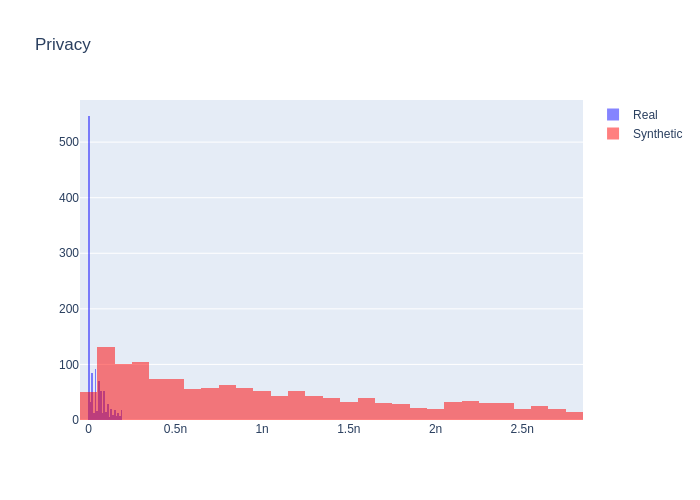

None

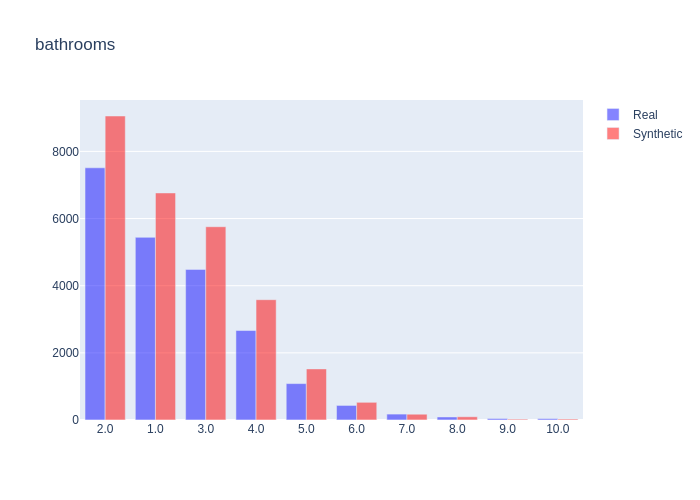

None

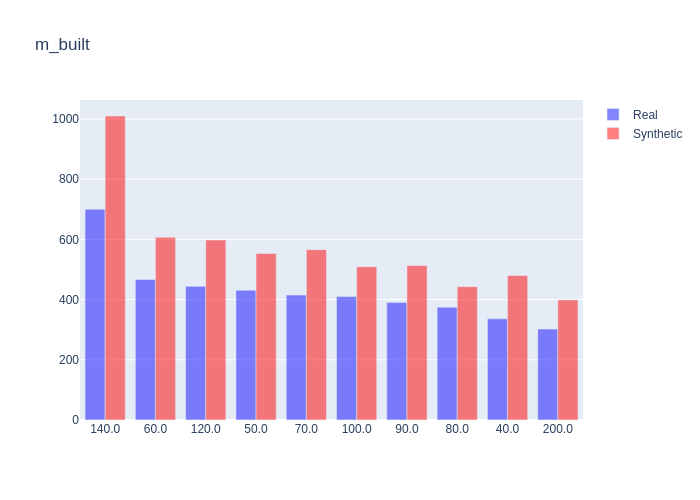

None

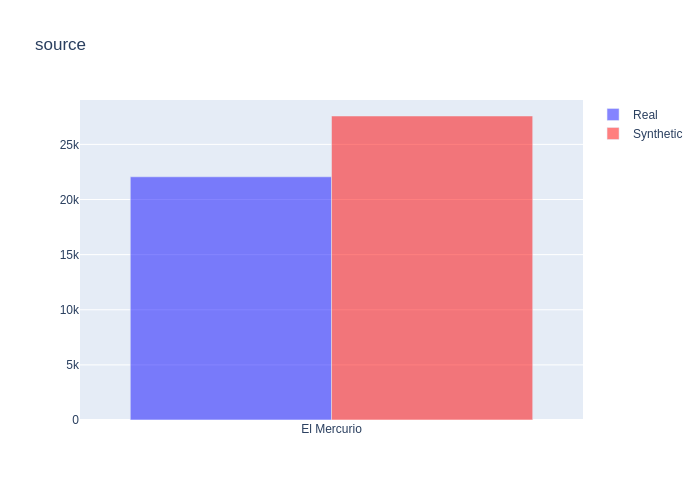

None

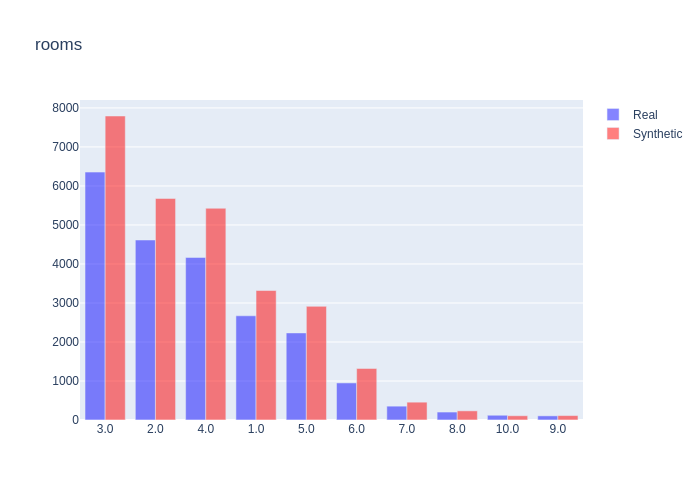

None

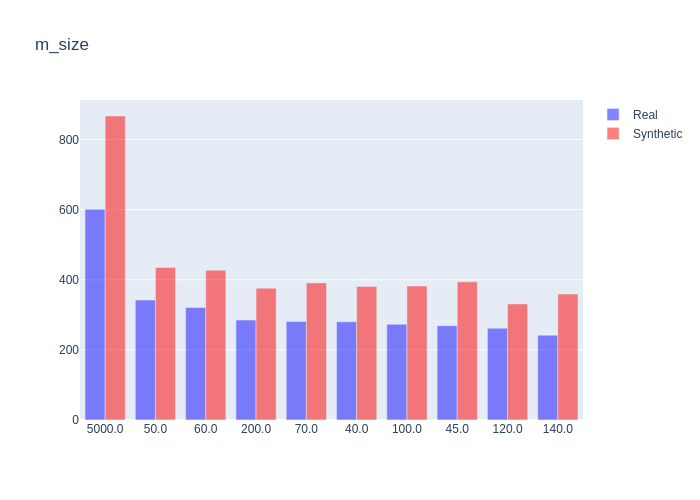

None

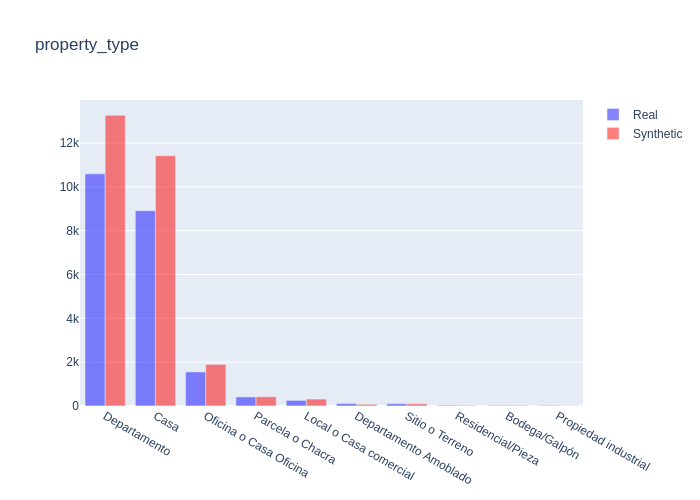

None

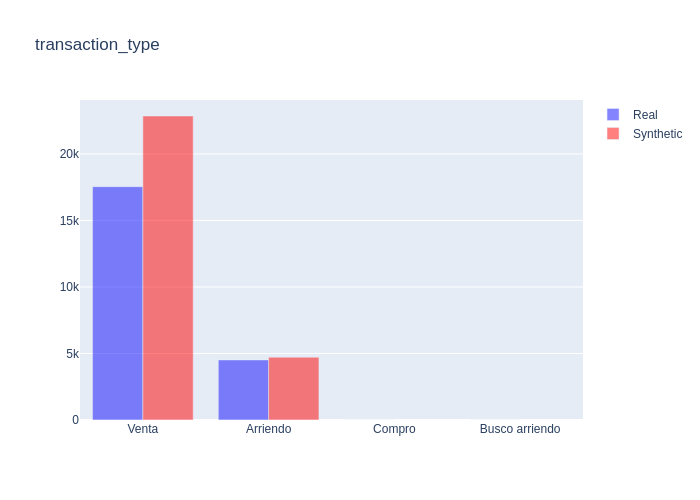

None

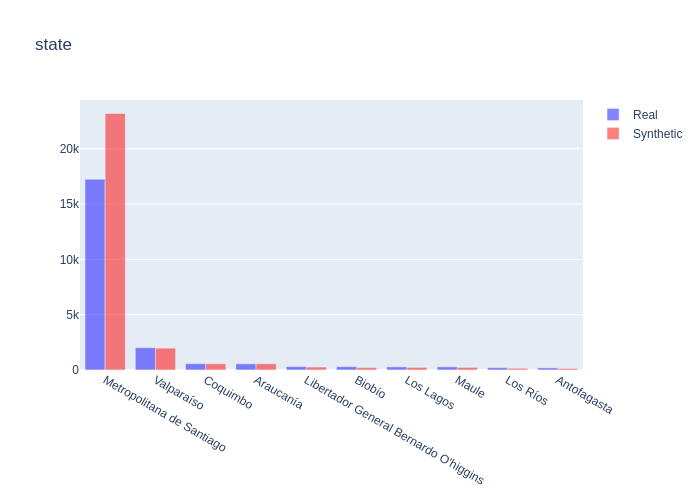

None

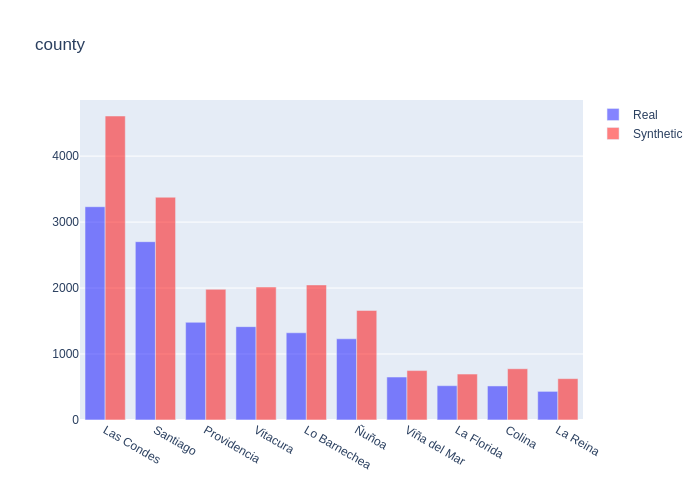

None

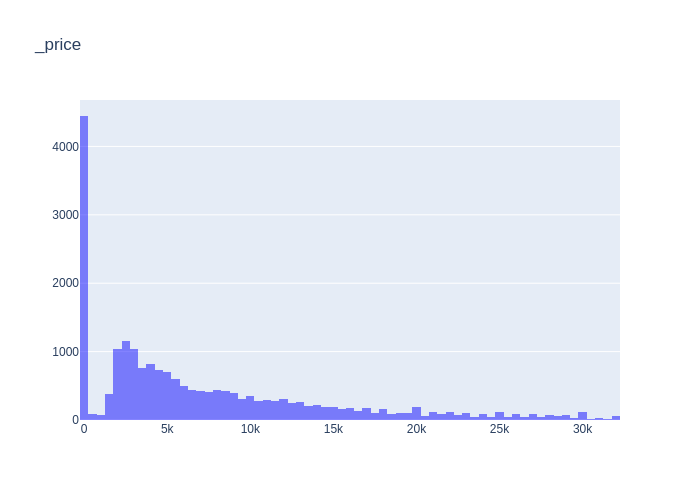

None

In [23]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

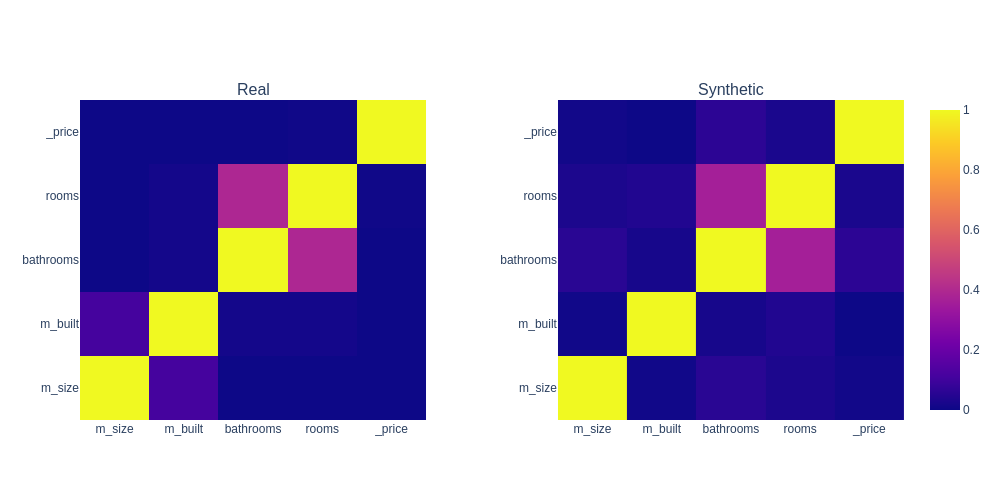

In [24]:
syn.charts.pair_corr(df.loc[:, syn.fake_data[best_model].columns].dropna(), syn.fake_data[best_model].astype({k:np.float64 for k in ('bathrooms','rooms','m_built','m_size')}), {'id', 'waterfront', 'yr_renovated'}, "_price").update_layout(dict(width=1000)).show("png")

In [25]:
syn.fake_data[best_model]

,url,_price,property_type,transaction_type,state,county,rooms,bathrooms,m_built,m_size,source
0,0,12.709801,Departamento,Arriendo,Metropolitana de Santiago,Santiago,2.0,1.0,40.0,38.0,El Mercurio
1,1,55000.000000,Casa,Venta,Metropolitana de Santiago,Vitacura,5.0,2.0,320.0,800.0,El Mercurio
2,2,98.457967,Casa,Arriendo,Metropolitana de Santiago,Lo Barnechea,6.0,4.0,300.0,1542.0,El Mercurio
3,3,4955.148519,Casa,Venta,Metropolitana de Santiago,Lampa,4.0,2.0,187.0,276.0,El Mercurio
4,4,3300.000000,Departamento,Venta,Metropolitana de Santiago,Santiago,1.0,1.0,45.0,39.0,El Mercurio
...,...,...,...,...,...,...,...,...,...,...,...
27569,27569,27.940719,Departamento,Arriendo,Metropolitana de Santiago,Las Condes,3.0,1.0,98.0,112.0,El Mercurio
27570,27570,4141.488503,Departamento,Venta,Valparaíso,Viña del Mar,2.0,2.0,71.0,66.0,El Mercurio
27571,27571,7365.882085,Parcela o Chacra,Venta,Antofagasta,Antofagasta,5.0,3.0,134.0,217.0,El Mercurio
27572,27572,19149.589430,Local o Casa comercial,Venta,Metropolitana de Santiago,Colina,7.0,5.0,197.0,5000.0,El Mercurio


In [26]:
syn.fake_data[second_best]

,url,publication_date,bathrooms,source,m_built,rooms,county,_price,transaction_type,property_type,m_size,state
0,0,2022-07-21 00:15:14.307839744,1.0,El Mercurio,45.0,2.0,Santiago,2310.867478,Venta,Departamento,45.0,Metropolitana de Santiago
1,1,2022-07-21 00:16:49.304465408,4.0,El Mercurio,140.0,4.0,Lo Barnechea,65.000000,Arriendo,Departamento,550.0,Metropolitana de Santiago
2,2,2022-07-21 20:05:00.000000000,1.0,El Mercurio,35.0,2.0,Santiago,15.005633,Arriendo,Departamento,35.0,Metropolitana de Santiago
3,3,2020-08-30 14:35:03.384176128,1.0,El Mercurio,40.0,1.0,Providencia,12.555370,Arriendo,Departamento,37.0,Metropolitana de Santiago
4,4,2022-02-24 00:01:41.356463616,1.0,El Mercurio,49.0,2.0,Santiago,3350.000000,Venta,Departamento,49.0,Metropolitana de Santiago
...,...,...,...,...,...,...,...,...,...,...,...,...
27569,2569,2022-02-23 08:05:46.451980800,2.0,El Mercurio,180.0,2.0,Vitacura,26988.000000,Venta,Departamento,414.0,Metropolitana de Santiago
27570,2570,2022-02-23 22:09:00.000000000,3.0,El Mercurio,165.0,4.0,Providencia,10000.000000,Venta,Departamento,114.0,Metropolitana de Santiago
27571,2571,2022-07-21 00:15:16.968445184,3.0,El Mercurio,110.0,4.0,Las Condes,10700.000000,Venta,Departamento,140.0,Metropolitana de Santiago
27572,2572,2022-02-23 22:06:51.435665664,2.0,El Mercurio,164.0,3.0,Las Condes,13900.000000,Venta,Casa,257.0,Metropolitana de Santiago


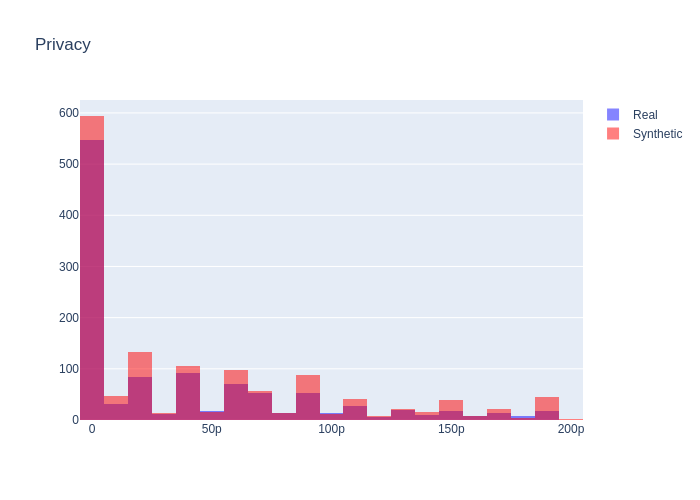

None

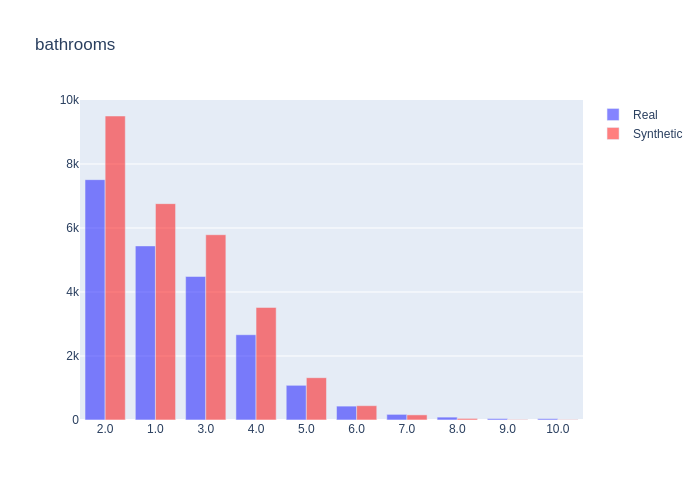

None

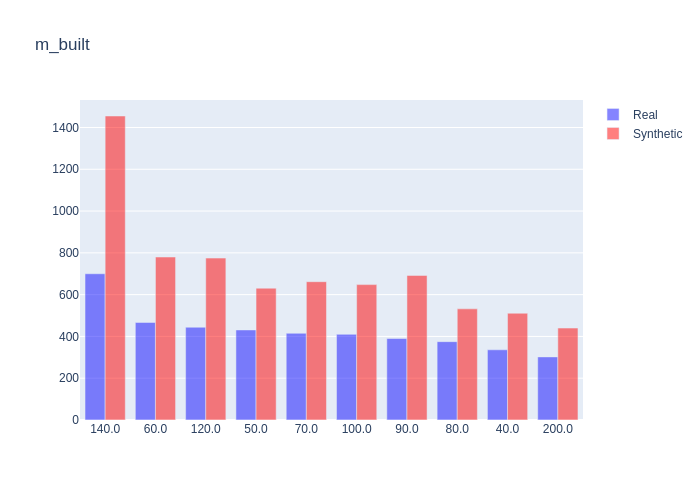

None

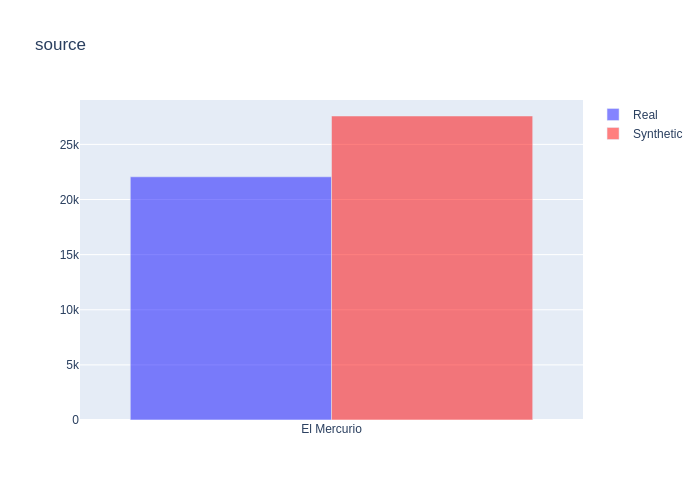

None

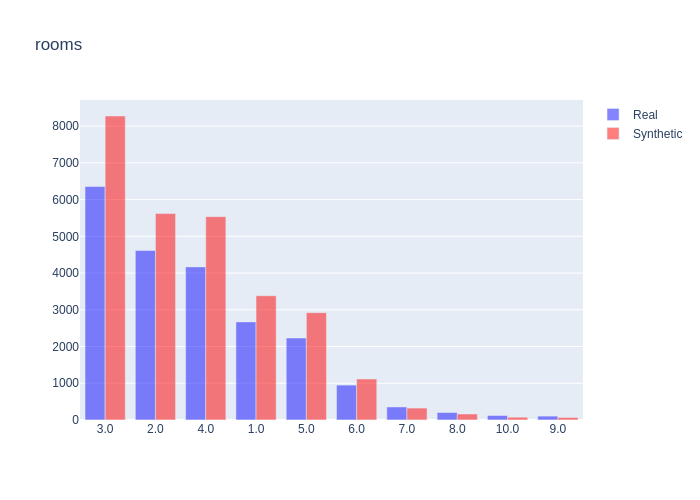

None

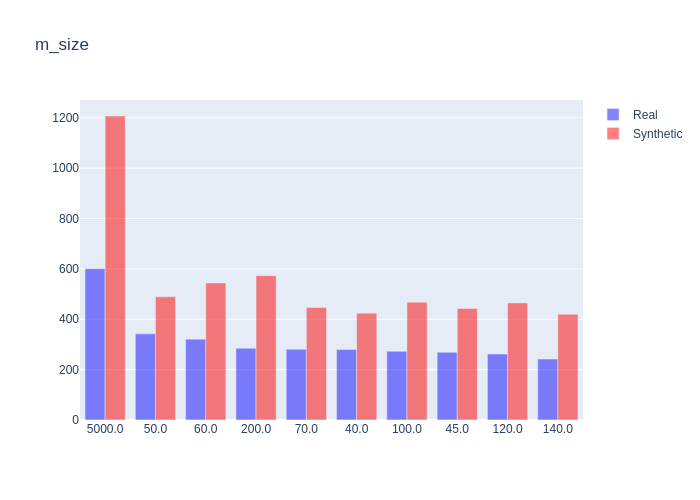

None

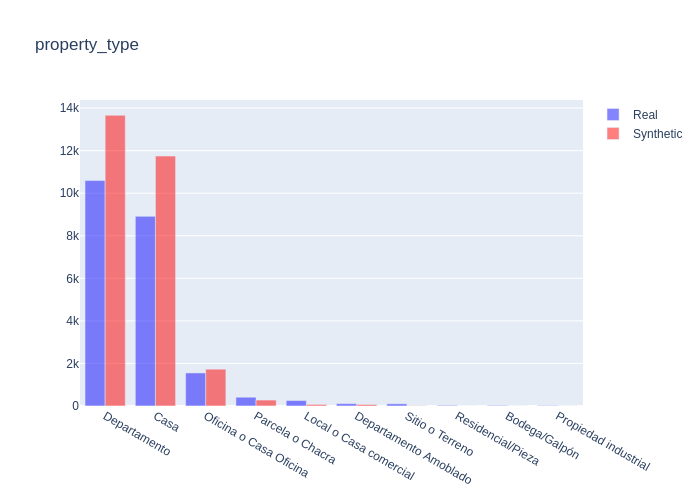

None

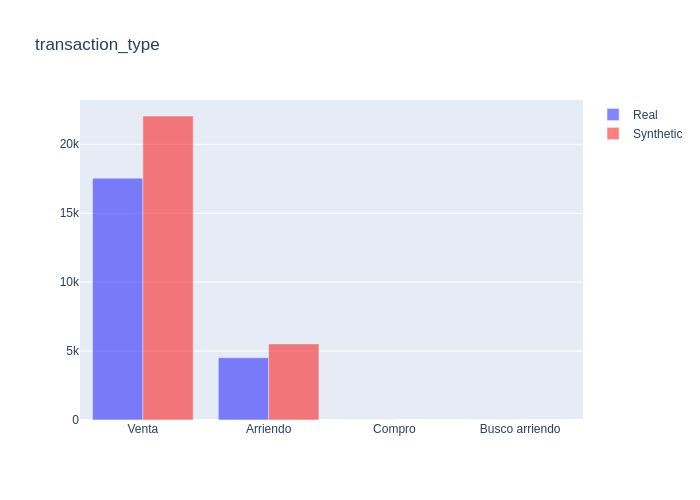

None

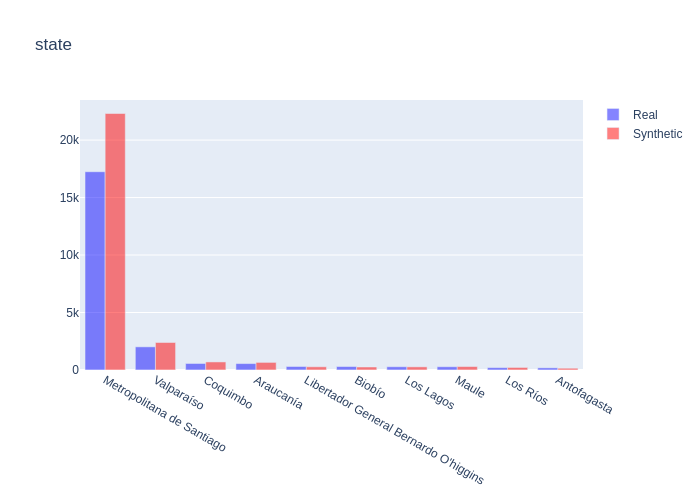

None

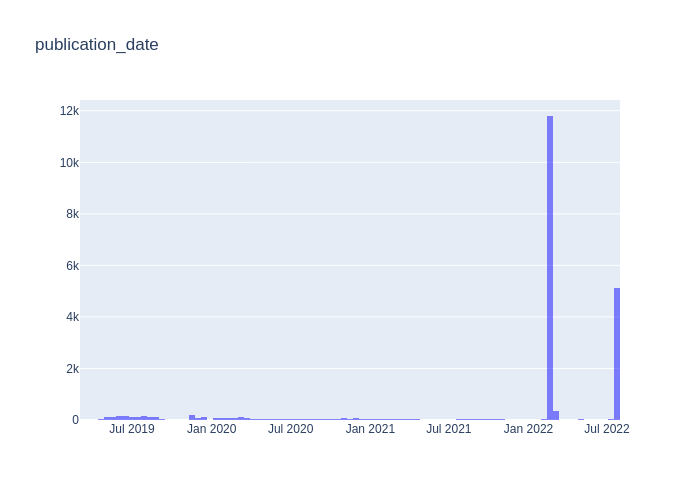

None

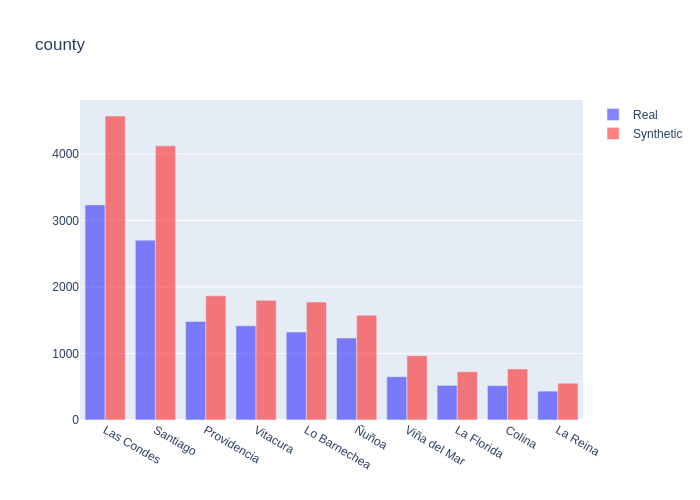

None

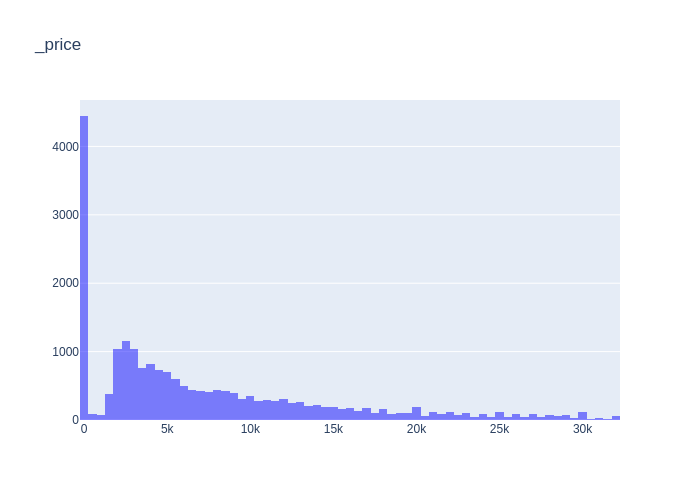

None

In [27]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(second_best, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))